# Ground Navigation for Aerial Vehicles

With a satellite reference image, we intend to utilize a SfM solution to match ground segments of images to the reference map.
- Inputs: Reference image (satellite), SfM solution (images, points, cameras), selected images (5)
- Output: Correction solutions for translation, rotation, scaling

Checklist
1. [x] Load in satellite image values 
2. [x] Choose ground segment in each image
3. [x] Load ground segments into a plot
4. [x] Implement an initial guess
5. [x] NEW SSD process on each
6. [ ] Create a correction vector for each
7. [ ] Visualization of each correction vector

Other things to do:
- [ ] More ground plane points
- [ ] Better initial guess***

Things to make faster 
- [x] grab_image_pts
- [x] ssd_nxn
- [ ] Further efficiency for ssd??

In [1]:
import numpy as np
import cv2
import open3d as o3d
import plotly.graph_objects as go
import plotly.io as pio
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree
import imageio
# %matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.path import Path

from groundNAV_agent import *
from colmapParsingUtils import *

# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# NOTES: 
# OS in JUMBOS: IMG_9446; ID = 4
# 40yd (far hash): IMG_9520; ID = 78
# Jumbo logo: IMG_9531; ID = 89
# 30yd (near hash): IMG_9542; ID = 100
# U in JUMBOS: IMG_9576; ID = 134

# New imgs - things near OS
# S: top half: IMG_9449
# O in Jumbos: IMG_9459
# Section of B in Jumbos: IMG_9467
# Edge to endzone nearside: IMG_9473
# 10 yd nearside: IMG_9476

In [3]:
# # Load in necessary parameters for gNAV agent 
# # Define Class Parameters 

# images_colm  = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/images.txt"
# cameras_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/cameras.txt"
# pts3d_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/points3D_f.txt"

# # Images selected for local corrections
# image_1 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9446.JPEG" #ID:4
# image_2 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9520.JPEG" #ID:78
# image_3 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9531.JPEG" #ID:89
# image_4 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9542.JPEG" #ID:100
# image_5 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9576.JPEG" #ID:134
# # Load in satellite reference image
# sat_ref = "TTurf/TurfSat.jpg"
# # sat_ref = cv2.imread('TTurf/TurfSat.jpg')

# # Organize for agent params
# images = [image_1, image_2, image_3, image_4, image_5]

In [4]:
# CLOSER IMAGES 
# Load in necessary parameters for gNAV agent 
# Define Class Parameters 

images_colm  = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/images.txt"
cameras_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/cameras.txt"
pts3d_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/points3D_f.txt"

# Images selected for local corrections
image_1 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9449.JPEG"
image_2 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9459.JPEG"
image_3 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9467.JPEG"
image_4 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9473.JPEG"
image_5 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9476.JPEG"
# Load in satellite reference image
sat_ref = "TTurf/TurfSat.jpg"
# sat_ref = cv2.imread('TTurf/TurfSat.jpg')

# Organize for agent params
images = [image_1, image_2, image_3, image_4, image_5]

In [5]:
# Create class
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, images, sat_ref)

# Grab raw points and RGB data for scene and reference cloud
scene_pts, rgb_data = gnav.grab_pts(gnav.pts3d_c)
ref_pts, ref_rgb = gnav.ref_pts, gnav.ref_rgb

In [6]:
# Use ground plane pts to set reference frame 
# Need gravity and height
pts_gnd_idx = np.array([25440, 25450, 25441, 25449, 25442, 25445, 103922, 103921, 103919, 103920])
tform_ref_frame = gnav.set_ref_frame(pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
# print("\nReference frame transformation\n", tform_ref_frame)

In [7]:
# Transform all points to the new coordinate system 
# Not necessary since we aren't using the cloud, but a good visual check for coord frame
tform_ref_frame_inv = gnav.inv_homog_transform(tform_ref_frame)
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(scene_pts, gnav.origin_w, tform_ref_frame_inv)
# print(origin_ref)
# Transform scene cloud to 2D (also as a visual check)
# Note: 2d projection will look off with z=-1; see TTurf_v2 for cropping method
scene_ref_2d = gnav.proj_2d_scene(scene_pts_ref)
# print(scene_ref_2d)

### Grab ground plane points from each desired image 

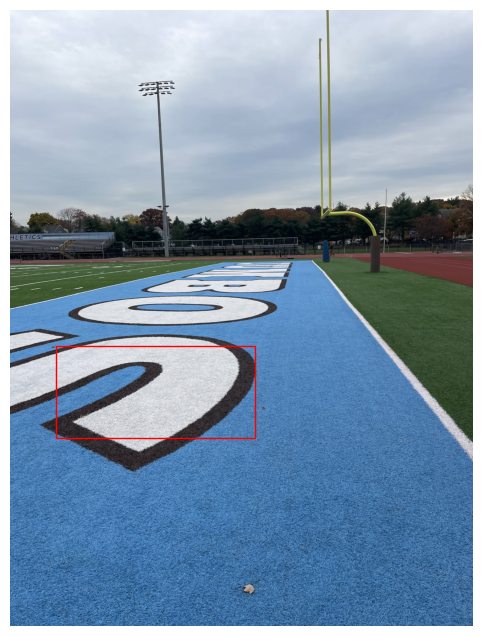

[[[ 300 2200]
  [ 301 2200]
  [ 302 2200]
  ...
  [1597 2200]
  [1598 2200]
  [1599 2200]]

 [[ 300 2201]
  [ 301 2201]
  [ 302 2201]
  ...
  [1597 2201]
  [1598 2201]
  [1599 2201]]

 [[ 300 2202]
  [ 301 2202]
  [ 302 2202]
  ...
  [1597 2202]
  [1598 2202]
  [1599 2202]]

 ...

 [[ 300 2797]
  [ 301 2797]
  [ 302 2797]
  ...
  [1597 2797]
  [1598 2797]
  [1599 2797]]

 [[ 300 2798]
  [ 301 2798]
  [ 302 2798]
  ...
  [1597 2798]
  [1598 2798]
  [1599 2798]]

 [[ 300 2799]
  [ 301 2799]
  [ 302 2799]
  ...
  [1597 2799]
  [1598 2799]
  [1599 2799]]]


In [24]:
# Image 1 - OS in Jumbos OR top half of S

# # OS in Jumbos 
# imnum = 0
# # x,y = 150,1725
# # side_x = 2250 # WIDTH
# # side_y = 750 # HEIGHT
# x,y = 150, 2000
# side_x = 1500
# side_y = 250 # HEIGHT

# Top half of S
imnum = 0
x,y = 300,2100
side_x = 1300 # WIDTH
side_y = 750 # HEIGHT
x,y = 300,2200
side_x = 1300 # WIDTH
side_y = 600 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
print(pts_loc)
# print(pts_rgb)

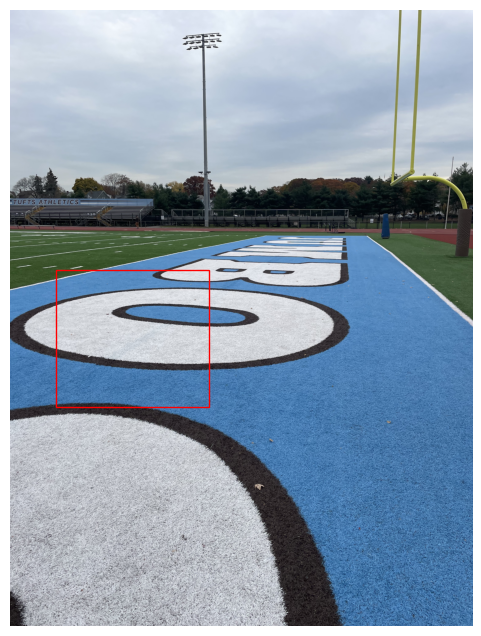

In [25]:
# Image 2 - 40yd (far), OR O in jumbos

# # 40yd (far)
# imnum = 1
# x,y = 1150,1150
# side_x = 1100 # WIDTH
# side_y = 900 # HEIGHT

# O in jumbos 
imnum = 1
x,y = 300,1700
side_x = 1000 # WIDTH
side_y = 900 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

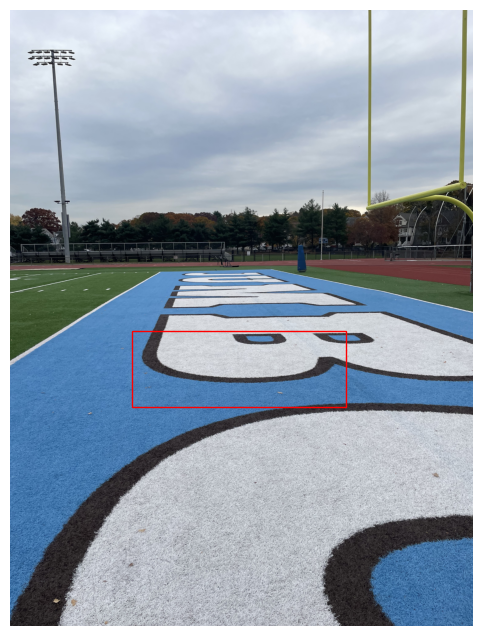

In [26]:
# Image 3 - Jumbo logo OR B in jumbos

# # Jumbo logo
# imnum = 2
# x,y = 400,1500
# side_x = 1500 # WIDTH
# side_y = 750 # HEIGHT

# B in jumbos 
imnum = 2
x,y = 800,2100
side_x = 1400 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

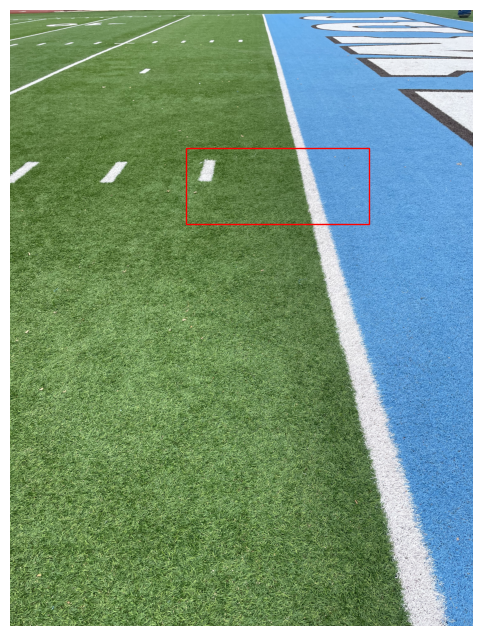

In [27]:
# Image 4 - 30yd (near) OR edge to endzone 

# 30yd (near)
# imnum = 3
# x,y = 1350,1450
# side_x = 1200 # WIDTH
# side_y = 500 # HEIGHT

# Edge to endzone
imnum = 3
x,y = 1150,900
side_x = 1200 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

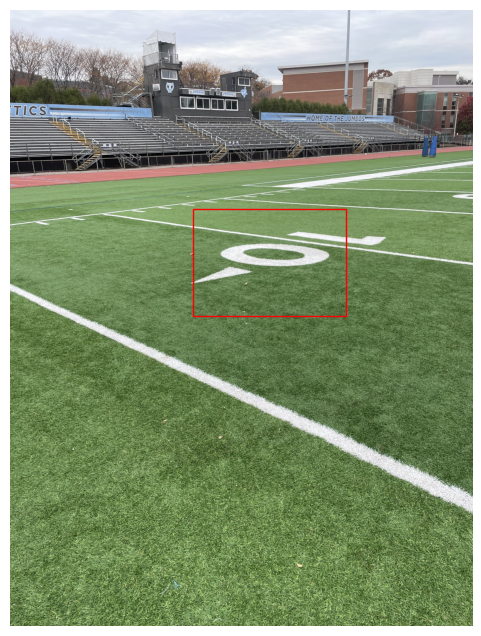

In [28]:
# Image 5 - U in Jumbos
imnum = 4
x,y = 1200,1300
side_x = 1000 # WIDTH
side_y = 700 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

In [29]:
# Generate projection of image sections 
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    # Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # Get transformation matrix that move from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)
    # VERIFICATION PURPOSES - DELETE WHEN DONE 
    # print(pts_vec_c)

    # Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    # VERIFICATION PURPOSES - DELETE WHEN DONE 
    # print(pts_vec_w)
    
    # Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)
    # VERIFICATION PURPOSES - DELETE WHEN DONE 
    # print(new_pts_w)

    # Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4


### Initial Guess

In [36]:
# Implementing an initial guess for the local image 

# SCALE for initial guess 
# scale = gnav.focal/39
# scale = 78 # Decent average guess (not actually, need to change)
scale = 87 # Guess for OS specifically (Original OS)

# # Translation and Rotation for initial guess
# # Decent averge guess 
# x = 330
# y = 248
# yaw = -1
# # Intermediate corrected guess
# x = 340
# y = 271
# yaw = -1

# Guess for OS specifically 
x = 294
y = 172
yaw = 1
# # # Corrected guess! (NO ITS NOT)
# x = 287
# y = 178
# yaw = 0

tform_guess = gnav.tform_create(x,y,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale
# print(tform_guess)

for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    loc_im_pts = gnav.im_mosaic[i]['pts'].copy()
    loc_im_pts[:, :2] *= scale
    # Get new points 
    __, loc_im_pts_guess, loc_im_vec_guess = gnav.unit_vec_tform(loc_im_pts, gnav.origin_w, tform_guess)
    gnav.im_pts_best_guess[i] = {'pts': loc_im_pts_guess}
    # gnav.im_pts_best_guess[i]['tree'] = cKDTree(loc_im_pts_guess) # UNECESSARY 

    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4


In [70]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# Create point cloud for image points
im0_cloud = o3d.geometry.PointCloud()
im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0]['pts'])
im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# Create point cloud for image points
im1_cloud = o3d.geometry.PointCloud()
# im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[1]['pts'])
# im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# # Create point cloud for image points
# im2_cloud = o3d.geometry.PointCloud()
# im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[2]['pts'])
# im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# # Create point cloud for image points
# im3_cloud = o3d.geometry.PointCloud()
# im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[3]['pts'])
# im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# # Create point cloud for image points
# im4_cloud = o3d.geometry.PointCloud()
# im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[4]['pts'])
# im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# Add necessary geometries to visualization 
vis.add_geometry(axis_origin)
vis.add_geometry(im0_cloud)
# vis.add_geometry(im1_cloud)
# vis.add_geometry(im2_cloud)
# vis.add_geometry(im3_cloud)
# vis.add_geometry(im4_cloud)
vis.add_geometry(ref_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 94
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 94
pci id for fd 94: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


### SSD Process - NEW VERSION

Steps:
- [x] Get four corners of image pts
- [x] Generate a polygon based on corners
- [x] Grab satellite points within polygon
- [x] Find nearest wedge point
- [x] SSD
- [x] Create functions within agent file

Notes: 
- Number of points in SSD process: 19693
- Divided by 5: 3939 (9800 when / 2)

In [88]:
n = 0
# for imnum in range(len(images)):
# Just for the first image for now 
for imnum in range(1):
# for imnum in range(4, 5, 1):
    ssds = gnav.ssd_nxn(n, imnum)
    gnav.ssds_curr[imnum] = ssds
print("Done, most recent SSDs are\n", ssds)

Number of points used for image 0:  (1631,)
Done, most recent SSDs are
 [[43.09898891]]


NEW SSD Process - TESTING
Old attempt shown in V3
1. [x] Total guess in reference plane --> reference plane
2. [x] Reference plane --> world coords
3. [x] World points --> camera pts
4. [x] 3d camera pts --> 2d camera points
5. [x] Shift to proper coords 
6. [x] Round pixel locations
7. [ ] Compare intensities for SSD
8. [ ] APPLY TO SAT pts

In [89]:
print(gnav.ssds_curr)

{0: array([[43.09898891]])}


In [90]:
# NEW new LOOKUP STRATEGY - SHOULD BE FASTER - NOT WORKING (yet)
n = 0
# for imnum in range(len(images)):
# Just for the first image for now 
for imnum in range(1):
    ssds1 = gnav.ssd_nxn_NEWnew(n, imnum)
    gnav.ssds1_curr[imnum] = ssds1
print("Done, SSDs are\n", ssds1)

[[0.81960785 0.5882353  0.36862746]
 [0.80784315 0.5882353  0.37254903]
 [0.8117647  0.5882353  0.38431373]
 ...
 [0.8862745  0.8666667  0.85490197]
 [0.94509804 0.9254902  0.92156863]
 [0.8156863  0.79607844 0.7921569 ]]

Nearest Intensities
 [0.6323804  0.62930983 0.63182354 ... 0.8711883  0.93090594 0.8014941 ]
Number of points used:  (1631,)
Done, SSDs are
 [[44.82591215]]


In [91]:
(0.299*0.7254902) + (0.587*0.5058824) + (0.114*0.2901961)

0.5469568939999999

In [92]:
print(np.sum(gnav.ints1))
print(np.sum(gnav.ints2))

1119.7334
1118.9066156862746


In [93]:
print(np.sort(gnav.ints1))
print(np.sort(gnav.ints2))
print(np.argmin(gnav.ints1))
print(min(gnav.ints1))
# print(gnav.check_pts[-5,-5])

[0.02698039 0.03825491 0.04614118 ... 0.9770706  0.9779647  0.99590987]
[0.02261176 0.04221961 0.05786275 ... 0.98099216 0.99725098 0.99865882]
1348
0.026980394


In [77]:
# Checking 2D points the algorithm comes up with
# Load in images
im_0 = gnav.images_dict[0]
# print(im_0)

image_rgb = cv2.cvtColor(im_0, cv2.COLOR_BGR2RGB)

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
plt.imshow(image_rgb)
# Plot the points with corresponding RGB colors
plt.scatter(gnav.check_pts[10,10][:,0], gnav.check_pts[10,10][:,1], color=[1, 0, 0], s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.scatter(gnav.check_pts[-10,-10][:,0], gnav.check_pts[-10,-10][:,1], color=[0, 1, 0], s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.scatter(gnav.check_pts[0,0][:,0], gnav.check_pts[0,0][:,1], color=[0, 0, 1], s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
# plt.scatter(gnav.check_pts[0,0][:125,0], gnav.check_pts[0,0][:125,1], color=[1, 0, 0], s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.scatter(356, 2665, color=[0,1,0], s=2)



# # Optionally, set axis limits for better viewing if needed
# plt.xlim([min(-y_shift), max(-y_shift)])
# plt.ylim([min(x_shift), max(x_shift)])

# # Flip the y-axis to match the image's coordinate system
# plt.gca().invert_yaxis()


plt.axis("off")
plt.show()

### SANITY PLOTTING

In [78]:
# pointsn10n10 = gnav.check_pts_sat[-10,-10]
# points1010 = gnav.check_pts_sat[10,10]
points00 = gnav.check_pts_sat[0,0][:125,:]
points00full = gnav.check_pts_sat[0,0]
print(points00)
# points10n9 = gnav.check_pts_sat[10,-9]
# points0n10 = gnav.check_pts_sat[0,-10]
# print(points1010, pointsn10n10, points00)

[[768. 659.   1.]
 [769. 659.   1.]
 [770. 659.   1.]
 [771. 659.   1.]
 [772. 659.   1.]
 [773. 659.   1.]
 [774. 659.   1.]
 [775. 659.   1.]
 [776. 659.   1.]
 [777. 659.   1.]
 [778. 659.   1.]
 [779. 659.   1.]
 [780. 659.   1.]
 [781. 659.   1.]
 [782. 659.   1.]
 [783. 659.   1.]
 [784. 659.   1.]
 [785. 659.   1.]
 [786. 659.   1.]
 [787. 659.   1.]
 [788. 659.   1.]
 [789. 659.   1.]
 [790. 659.   1.]
 [791. 659.   1.]
 [792. 659.   1.]
 [793. 659.   1.]
 [794. 659.   1.]
 [795. 659.   1.]
 [796. 659.   1.]
 [797. 659.   1.]
 [798. 659.   1.]
 [799. 659.   1.]
 [800. 659.   1.]
 [801. 659.   1.]
 [802. 659.   1.]
 [803. 659.   1.]
 [804. 659.   1.]
 [805. 659.   1.]
 [806. 659.   1.]
 [807. 659.   1.]
 [808. 659.   1.]
 [809. 659.   1.]
 [810. 659.   1.]
 [811. 659.   1.]
 [812. 659.   1.]
 [769. 660.   1.]
 [770. 660.   1.]
 [771. 660.   1.]
 [772. 660.   1.]
 [773. 660.   1.]
 [774. 660.   1.]
 [775. 660.   1.]
 [776. 660.   1.]
 [777. 660.   1.]
 [778. 660.   1.]
 [779. 660

In [79]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="ROI poly visualization for new SSD (with sat ref)")

# Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# Create point cloud for image points
im0_cloud = o3d.geometry.PointCloud()
im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0]['pts'])
im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

cloud_00 = o3d.geometry.PointCloud()
cloud_00.points = o3d.utility.Vector3dVector(points00)
cloud_00.paint_uniform_color([1, 0, 0])  # RGB for red (1, 0, 0)

cloud_00f = o3d.geometry.PointCloud()
cloud_00f.points = o3d.utility.Vector3dVector(points00full)
cloud_00f.paint_uniform_color([0, 0, 1])  # RGB for red (1, 0, 0)

# cloud_1010 = o3d.geometry.PointCloud()
# cloud_1010.points = o3d.utility.Vector3dVector(points10n9)
# cloud_1010.paint_uniform_color([0, 1, 0])  # RGB for red (1, 0, 0)

# cloud_n10n10 = o3d.geometry.PointCloud()
# cloud_n10n10.points = o3d.utility.Vector3dVector(pointsn10n10)
# cloud_n10n10.paint_uniform_color([0, 0, 1])  # RGB for red (1, 0, 0)

# Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
vis.add_geometry(ref_cloud)
# vis.add_geometry(im0_cloud)
vis.add_geometry(cloud_00f)
vis.add_geometry(cloud_00)
# vis.add_geometry(cloud_1010)
# vis.add_geometry(cloud_n10n10)



# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 94
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 94
pci id for fd 94: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [80]:
# print(min(gnav.check_pts[:,0]))
# print(min(gnav.check_pts[:,1]))
# print(gnav.images_dict[0][356,2665])

In [81]:
a = gnav.images_dict[0][2665,356].astype(np.float32)
a /= 255
inten = 0.299 * a[0] + 0.587 * a[1] + 0.114 * a[2]
print(inten)

0.04266666784882545


# NOTES
- Better SSD strategy implementation
- However, SSD result does not match
- Show mismatched intensity values
- Potentially partially a sorting issue (but not fully)
- SSD slightly off, but intensity values show more
- Differences in grabbing from the image vs the mosaic????
- However, its faster!! (just doesn't work yet)

### Plotting SSD RESULTS 

In [87]:
# Plot and visualize SSD values 

# Create a 5x5 grid of x and y coordinates
x = np.linspace(-n, n, 2*n+1)
y = np.linspace(-n, n, 2*n+1)
Y, X = np.meshgrid(x, y)
# print(ssds)

# print(x)
# print(X)
# print(Y)

# Best shift
idrow, idcol = np.unravel_index(np.argmin(ssds), ssds1.shape)
print(idrow, idcol)
shiftx_min = idrow-n
shifty_min = idcol-n
print("BEST SHIFT = ", shiftx_min, shifty_min)
print("BEST SSD = ", ssds[idrow, idcol])

10 10
BEST SHIFT =  0 0
BEST SSD =  43.09898890609766


In [83]:
print("SSDs\n", ssds)
print("SSDs1\n", ssds1)

SSDs
 [[308.11680541 303.25321583 299.39870628 295.9665452  291.94428059
  287.02408273 281.01351843 275.09546869 269.68210171 264.51387392
  258.80362709 254.29717859 251.18793051 247.56327086 245.5833826
  244.72027773 243.67410958 242.99441722 243.17042721 244.02438129
  242.9748262 ]
 [282.91083807 274.1615426  267.50784977 262.61231843 258.84034685
  256.25072178 253.11219859 249.56358631 247.88474755 246.38381471
  244.44635004 243.9348194  244.23987573 243.72359387 242.65426048
  242.43393685 241.99455523 241.0343916  241.00386894 240.80674143
  240.31350185]
 [254.24317161 245.03712996 239.61478781 236.57887252 236.58270326
  238.06168738 239.81426878 240.48930432 240.99507315 242.18831187
  242.7222371  242.76811807 242.77340342 242.7151705  242.02989973
  240.54263467 239.49344212 238.10681282 237.38939663 236.51961251
  236.38235629]
 [235.75650417 228.88258918 225.7540206  225.27890386 227.911867
  232.338019   236.93940761 240.42083152 241.31695846 241.82339866
  242.03162

In [85]:
# PLOTTING A SINGLE VECTOR FIELD FOR SSD
# Create the figure and 3D axis
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D vectors
ax.quiver(X, Y, np.zeros_like(ssds), np.zeros_like(ssds), np.zeros_like(ssds), (ssds/100)**2, arrow_length_ratio=0.1)

# Set axis limits
ax.set_xlim([-11, 11])  # X axis range
ax.set_ylim([-11, 11])  # Y axis range
ax.set_zlim([0, (np.max(ssds) / 100)**2])  # Z axis range, adjust based on your data

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pixel Correction Vector Field')

Text(0.5, 0.92, 'Pixel Correction Vector Field')

### Create a vector for each SSD 

In [ ]:
# Create a vector from the original position to the minimum SSD location 
cor_vecs = np.zeros((len(images), 2))
base_vec = np.zeros((len(images), 2))
for imnum in range(len(images)):
# for imnum in range(1):
    # Grab SSDs - get id of minimum
    ssds = gnav.ssds_curr[imnum]
    # print(f"\nSSDS for image {imnum}\n", ssds)
    idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
    # print(idrow, idcol)
    # Define best shift vector 
    shiftx_min = idrow-n
    shifty_min = idcol-n
    print("\nBEST SHIFT VECTOR = ", shiftx_min, shifty_min)
    print(f"\nBEST SSD for image {imnum} = ", ssds[idrow, idcol])
    cor_vecs[imnum] = shiftx_min, shifty_min
    # Get mean of satellite points for base of x and y
    sat_pts, __ = gnav.get_inside_sat_pts(imnum, 0,0)#shiftx_min, shifty_min)
    # print(sat_pts)
    basex, basey = np.mean(sat_pts[:,0]), np.mean(sat_pts[:,1])
    print("\nBase of x and y = ", basex, basey)
    base_vec[imnum] = basex, basey

print("\nCorrection vectors:\n", cor_vecs)
print("\nBase of correction vectors: \n", base_vec)

points_b = np.hstack((base_vec, np.zeros((len(images), 1))))
points_e = points_b + np.hstack((cor_vecs, np.zeros((len(images),1))))
points = np.vstack((points_b, points_e))
# print("\nBeginning of points: \n", points_b)
# print("\nEnd of points: \n",points_e)
print("\nAll points: \n",points)
lines = []
for i in range(len(images)):
    lines.append([i,i+len(images)])
    # print(i, i+len(images))

print("\nLines for OPEN3d:\n",lines)

### Least squares 

delta y = J*delta alpha

In [ ]:
# Parameters (from initial guess)
s = 78
theta = np.deg2rad(-1)
tp = 330
tq = 248

# Delta y term
# print(cor_vecs.reshape(-1,1))
yi = cor_vecs.reshape(-1,1)
# print(yi)

# Form jacobian for each image
J = np.zeros((2*len(images),4))
# print(J)
for imnum in range(len(images)):
    xpi = np.mean(gnav.im_pts_best_guess[imnum]['pts'][:,0])
    xqi = np.mean(gnav.im_pts_best_guess[imnum]['pts'][:,1])
    print(xpi, xqi)
    # Jacobian values (2x4)
    j11 = np.cos(theta)*xpi - np.sin(theta)*xqi
    j21 = np.sin(theta)*xpi + np.cos(theta)*xqi
    j12 = -s*(np.sin(theta)*xpi + np.cos(theta)*xqi)
    j22 = s*(np.cos(theta)*xpi - np.sin(theta)*xqi)
    j13, j23, j14, j24 = 1, 0, 0, 1
    # print(j13)

    # Construct Jacobian 
    J_upper = np.hstack((j11, j12, j13, j14))  # First row block (y_p terms)
    # print("\nJ Upper\n", J_upper)
    J_lower = np.hstack((j21, j22, j23, j24))  # Second row block (y_q terms)
    # print("\nJ Lower\n", J_lower)
    j = np.vstack((J_upper, J_lower))  # Shape (2N, 4)
    # print("\nJacobian\n", j)
    J[2*imnum:2*imnum+2, :] = j

print("\nJACOBIAN\n", J)
print("\nJacobian shape: ", J.shape)

# Least squares process
JTJi = np.linalg.inv(J.T@J)
Dalpha = JTJi@J.T@yi
print("\nDelta Alpha:\n", Dalpha)

# Plotting Tools

In [ ]:
# # PLOTTING THE ORIGINAL SCENE WITH THE ORIGINAL ORIGIN 

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Originial scene with ORIGINAL ORIGIN")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for scene points
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(scene_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING the SATELLITE REFERENCE image as a cloud

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Originial scene with ORIGINAL ORIGIN")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=500)

# # Create point cloud for scene points
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(ref_pts)
# scene_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(scene_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING THE ORIGINAL SCENE WITH THE REFERENCE ORIGIN 

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Originial scene with REFERENCE ORIGIN")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for scene points
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(scene_pts_ref)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(scene_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING THE ORIGINAL SCENE WITH THE REFERENCE ORIGIN 

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="2D PROJECTION scene with REFERENCE ORIGIN")

# # Create axes @ origin
# # axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100)

# # Create point cloud for scene points
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(scene_ref_2d)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

# # Add necessary geometries to visualization 
# # vis.add_geometry(axis_origin)
# vis.add_geometry(scene_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING THE NEW SCENE MOSAIC BEFORE INITIAL GUESS

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Mosaic scene with satellite reference")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for image points
# im0_cloud = o3d.geometry.PointCloud()
# im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['pts'])
# im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# # Create point cloud for image points
# im1_cloud = o3d.geometry.PointCloud()
# im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['pts'])
# im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# # Create point cloud for image points
# im2_cloud = o3d.geometry.PointCloud()
# im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['pts'])
# im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# # Create point cloud for image points
# im3_cloud = o3d.geometry.PointCloud()
# im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['pts'])
# im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# # Create point cloud for image points
# im4_cloud = o3d.geometry.PointCloud()
# im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['pts'])
# im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# # Create point cloud for reference cloud (satellite)
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
# ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(im0_cloud)
# vis.add_geometry(im1_cloud)
# vis.add_geometry(im2_cloud)
# vis.add_geometry(im3_cloud)
# vis.add_geometry(im4_cloud)
# vis.add_geometry(ref_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING THE NEW SCENE MOSAIC

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Mosaic scene with satellite reference")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for image points
# im0_cloud = o3d.geometry.PointCloud()
# im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0])
# im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# # Create lineset for adjustment vector 
# # Convert points and lines to numpy arrays
# points_n = np.array(points_n)
# lines_n = np.array(lines_n)
# # Create LineSet
# line_set = o3d.geometry.LineSet()
# line_set.points = o3d.utility.Vector3dVector(points_n)
# line_set.lines = o3d.utility.Vector2iVector(lines_n)
# line_set.paint_uniform_color([0, 1, 0])  # RGB for red (1, 0, 0)

# # Create point cloud for image points
# im1_cloud = o3d.geometry.PointCloud()
# im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[1])
# im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# # Create point cloud for image points
# im2_cloud = o3d.geometry.PointCloud()
# im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[2])
# im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# # Create point cloud for image points
# im3_cloud = o3d.geometry.PointCloud()
# im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[3])
# im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# # Create point cloud for image points
# im4_cloud = o3d.geometry.PointCloud()
# im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[4])
# im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# # Create point cloud for reference cloud (satellite)
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
# ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(im0_cloud)
# vis.add_geometry(line_set)
# vis.add_geometry(im1_cloud)
# vis.add_geometry(im2_cloud)
# vis.add_geometry(im3_cloud)
# vis.add_geometry(im4_cloud)
# vis.add_geometry(ref_cloud)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING THE NEW SCENE MOSAIC

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="ROI poly visualization for new SSD (with sat ref)")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for image points
# im0_cloud = o3d.geometry.PointCloud()
# im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0]['pts'])
# im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# corners_cloud = o3d.geometry.PointCloud()
# corners_cloud.points = o3d.utility.Vector3dVector(points)
# corners_cloud.paint_uniform_color([1, 0, 0])  # RGB for red (1, 0, 0)

# poly_sat = o3d.geometry.PointCloud()
# poly_sat.points = o3d.utility.Vector3dVector(inside_pts)
# poly_sat.paint_uniform_color([0, 0, 1])  # RGB for red (1, 0, 0)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(im0_cloud)
# vis.add_geometry(corners_cloud)
# vis.add_geometry(ref_cloud)
# vis.add_geometry(poly_sat)


# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOTTING A SINGLE VECTOR FIELD FOR SSD
# # Create the figure and 3D axis
# %matplotlib qt
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the 3D vectors
# ax.quiver(X, Y, np.zeros_like(ssds), np.zeros_like(ssds), np.zeros_like(ssds), (ssds/300)**2, arrow_length_ratio=0.1)

# # Set axis limits
# ax.set_xlim([-11, 11])  # X axis range
# ax.set_ylim([-11, 11])  # Y axis range
# ax.set_zlim([0, (np.max(ssds) / 300)**2])  # Z axis range, adjust based on your data

# # Labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Pixel Correction Vector Field')

In [ ]:
# # VISUALIZE ALL CORRECTION VECTORS 
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the 3D vectors
# ax.quiver(base_vec[:,0], base_vec[:,1], np.zeros_like(base_vec[:,0]),
#           cor_vecs[:,0], cor_vecs[:,1], np.zeros_like(base_vec[:,0]), length=20, normalize=True)

# # Set axis limits
# ax.set_xlim([550, 800])  # X axis range
# ax.set_ylim([500, 700])  # Y axis range
# ax.set_zlim([0, 1])  # Z axis range, adjust based on your data

# # Labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Pixel Correction Vector Field')

In [ ]:
# # PLOTTING THE NEW SCENE MOSAIC WITH CORRECTION VECTORS

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Mosaic scene with COORECTION VECTORS")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create lineset for adjustment vector 
# # Convert points and lines to numpy arrays
# points_n = np.array(points)
# lines_n = np.array(lines)
# # Create LineSet
# line_set = o3d.geometry.LineSet()
# line_set.points = o3d.utility.Vector3dVector(points_n)
# line_set.lines = o3d.utility.Vector2iVector(lines_n)
# line_set.paint_uniform_color([0, 1, 0])  # RGB for red (1, 0, 0)

# # Create point cloud for image points
# im0_cloud = o3d.geometry.PointCloud()
# im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0]['pts'])
# im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# # Create point cloud for image points
# im1_cloud = o3d.geometry.PointCloud()
# im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[1]['pts'])
# im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# # Create point cloud for image points
# im2_cloud = o3d.geometry.PointCloud()
# im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[2]['pts'])
# im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# # Create point cloud for image points
# im3_cloud = o3d.geometry.PointCloud()
# im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[3]['pts'])
# im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# # Create point cloud for image points
# im4_cloud = o3d.geometry.PointCloud()
# im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[4]['pts'])
# im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# # Create point cloud for reference cloud (satellite)
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
# ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(im0_cloud)
# vis.add_geometry(im1_cloud)
# vis.add_geometry(im2_cloud)
# vis.add_geometry(im3_cloud)
# vis.add_geometry(im4_cloud)
# vis.add_geometry(ref_cloud)
# vis.add_geometry(line_set)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()